# 2. Slices of different developmental stages
Integration and alignment of Stereo-seq data representing axolotl regenerative telencephalon at developmental stages 54 and 57

The Stereo-seq axolotl regenerative telencephalon dataset includes 18 brain tissue slices with single-cell resolution, capturing over 20,000 genes across various stages of regeneration and development. Two slices from developmental stages 54 and 57, containing 2,929 and 4,410 spatial spots respectively, were selected for alignment and integration.

## Preparation

In [1]:
import sys
import time
from spatialFuser import *
import scanpy as sc
import pandas as pd
import numpy as np
sys.path.append("..")

/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Hyper-Parameters setting
All hyperparameters are stored in the variable args. To display them during initialization, use the function call *args = def_training_args(show_detail=True)*.

SpatialFuser employs two-layer MCGATE models with high latent dimension to learn data embeddings as Stereo-seq is high-throughput spatial technology.

In [2]:
# load args:
print("============================================")
print("=              Setting Params              =")
slice_1_args = def_training_args()
slice_1_args.hidden = [512, 32]
slice_1_args.epochs = 500
slice_1_args.lr = 3e-4
slice_1_args.K = 4
slice_1_args.heads = 1
slice_1_args.alpha = 0

slice_2_args = def_training_args()
slice_2_args.hidden = [512, 32]
slice_2_args.epochs = 500
slice_2_args.lr = 3e-4
slice_2_args.K = 4
slice_2_args.heads = 1
slice_2_args.alpha = 0

integration_args = def_training_args()
integration_args.hidden = [32, 32]
integration_args.fusion_epoch = 200
integration_args.lr = 5e-3
integration_args.match_step_size = 10
integration_args.tau = 0.1
integration_args.roi_radius = 0.15
integration_args.epsilon = 1
integration_args.m_top_K = 2
integration_args.beta_rec = 60
integration_args.beta_dir = 1

=              Setting Params              =


## Load data
SpatialFuser provides a built-in data loading and preprocessing module, *SpatialFuserDataLoader*. The required inputs include hyperparameters, data_dir (the dataset storage directory), data_tech (either “seq-based” or “image-based”), and files (a list of h5ad files to be loaded).

For spatial omics data, *SpatialFuserDataLoader* constructs a KNN adjacency graph based on the specified value of K to support graph neural network training.

For seq-based data, spatially variable genes are extracted according to n_svgs to simplify the model.

For the Stereo-seq axolotl regenerative telencephalon dataset, we used the intersection of SVGs from two slices as the input features for the model.

All AnnData objects are normalized, log-transformed, and subsequently converted into PyG objects for model input.

In [3]:
# load data:
print("============================================")
print("=               Loading Data               =")
slice_1_dataLoader = SpatialFuserDataLoader(slice_1_args,
                                            data_dir='/public8/lilab/student/whcai/Integration/data/Stereo-seq_Axolotl_Brain',
                                            data_tech='seq-based',
                                            files=['Stereo-seq_wei2022single_Stage54_data.h5ad'])
slice_1_dataLoader.load_adata()
slice_1_dataLoader.pre_processing(n_svgs=3000, k_cutoff=slice_1_args.K, batch_label=[1])

slice_2_dataLoader = SpatialFuserDataLoader(slice_2_args,
                                            data_dir='/public8/lilab/student/whcai/Integration/data/Stereo-seq_Axolotl_Brain',
                                            data_tech='seq-based',
                                            files=['Stereo-seq_wei2022single_Stage57_data.h5ad'])
slice_2_dataLoader.load_adata()
slice_2_dataLoader.pre_processing(n_svgs=3000, k_cutoff=slice_2_args.K, batch_label=[2])

highly_variable_1 = slice_1_dataLoader.adata.var[slice_1_dataLoader.adata.var['highly_variable']].index
highly_variable_2 = slice_2_dataLoader.adata.var[slice_2_dataLoader.adata.var['highly_variable']].index

# find same SVGs
intersection_genes = np.intersect1d(highly_variable_1, highly_variable_2)
slice_1_dataLoader.adata.var['inter_SVGs'] = False
slice_1_dataLoader.adata.var.loc[intersection_genes, 'inter_SVGs'] = True
slice_2_dataLoader.adata.var['inter_SVGs'] = False
slice_2_dataLoader.adata.var.loc[intersection_genes, 'inter_SVGs'] = True
slice_1_dataLoader.adata = slice_1_dataLoader.adata[:, intersection_genes]
slice_2_dataLoader.adata = slice_2_dataLoader.adata[:, intersection_genes]

# anndata to PyG object
slice_1_dataLoader.generate_minibatch(loader_type='RandomNodeLoader', num_workers=5)
slice_1_dataLoader.adata.obs['Region'] = slice_1_dataLoader.adata.obs['Annotation']
slice_2_dataLoader.generate_minibatch(loader_type='RandomNodeLoader', num_workers=5)
slice_2_dataLoader.adata.obs['Region'] = slice_2_dataLoader.adata.obs['Annotation']

=               Loading Data               =


/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


=         Calculating spatial graph        =


/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


=         Calculating spatial graph        =


/tmp/ipykernel_32120/3314877572.py:23: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  slice_1_dataLoader.adata.var['inter_SVGs'] = False
/tmp/ipykernel_32120/3314877572.py:25: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  slice_2_dataLoader.adata.var['inter_SVGs'] = False


The PyG data u create is qualified
=The graph contains 14645 edges, 2929 cells=
=   5.0000 neighbors per cell on average   =
=              subgraph Info             =
=           Batch 0: 2929 nodes           =
=   4.0000 neighbors per cell on average   =
batch:[1.], node num:[2929]
The PyG data u create is qualified
=The graph contains 22050 edges, 4410 cells=
=   5.0000 neighbors per cell on average   =
=              subgraph Info             =


/tmp/ipykernel_32120/3314877572.py:32: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  slice_1_dataLoader.adata.obs['Region'] = slice_1_dataLoader.adata.obs['Annotation']


=           Batch 0: 4410 nodes           =
=   4.0000 neighbors per cell on average   =
batch:[2.], node num:[4410]


/tmp/ipykernel_32120/3314877572.py:34: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  slice_2_dataLoader.adata.obs['Region'] = slice_2_dataLoader.adata.obs['Annotation']


## Train

The MCGATEs are first pre-trained individually, after which the fusion layer and matching layer are incorporated into the training process.

In [4]:
# train
print("============================================")
print("=              Begin to Train              =")
training_time = time.time()
[adata1, adata2], trainer = train_integration([slice_1_args, slice_2_args, integration_args],
                                              [slice_1_dataLoader, slice_2_dataLoader])
print("=            Training Finished!            =")
print("Total time elapsed: {:.4f}s".format(time.time() - training_time))
print("============================================")

=              Begin to Train              =


/public8/lilab/student/whcai/Integration/model/SpatialFuser/spatialFuser/train.py:137: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  self.adata1_adata2atial_adj = torch.sparse.FloatTensor(batch_in_data1.edge_index,
Epoch 500 || adata1_pretrain_loss: 0.1709 || adata2_pretrain_loss: 0.1411 || : 100%|██| 500/500 [00:26<00:00, 18.92it/s]
Epoch 200 || Fusion_loss : 0.3371 || MSE_loss: 0.3147 || Dir_loss: 0.0966 || : 100%|██| 200/200 [00:12<00:00, 16.33it/s]


=            Training Finished!            =
Total time elapsed: 39.9277s


## Spatial domain detection after integration
SpatialFuser provides an evaluation module, *metrics*, for assessing tissue domain detection tasks. It treats the Region column in anndata.obs as the ground truth and, based on the provided embed_label (an array stored in anndata.obsm), automatically computes five metrics (ARI, AMI, Homogeneity, Completeness, and V-Measure) under clustering methods including Leiden, Louvain, and Mclust.

Here, we only present the spatial domains and Umap colored by Mclust. The original annotations were used as references for evaluation.

2025-08-25 20:17:47.202248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 20:17:47.406564: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 20:17:49.268331: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/cv2/../../lib64::/usr/local/

fitting ...
  |======================================================================| 100%


/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


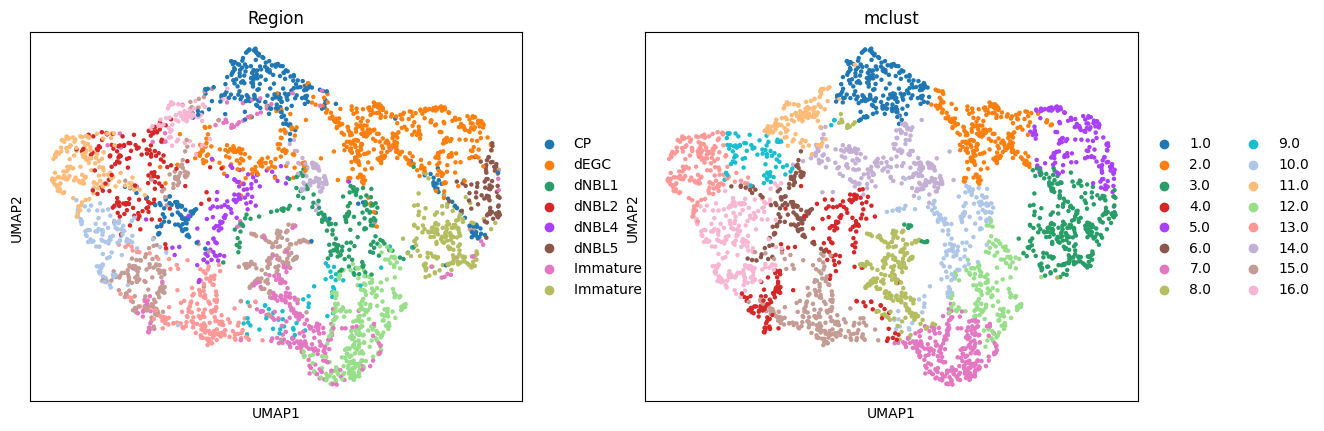

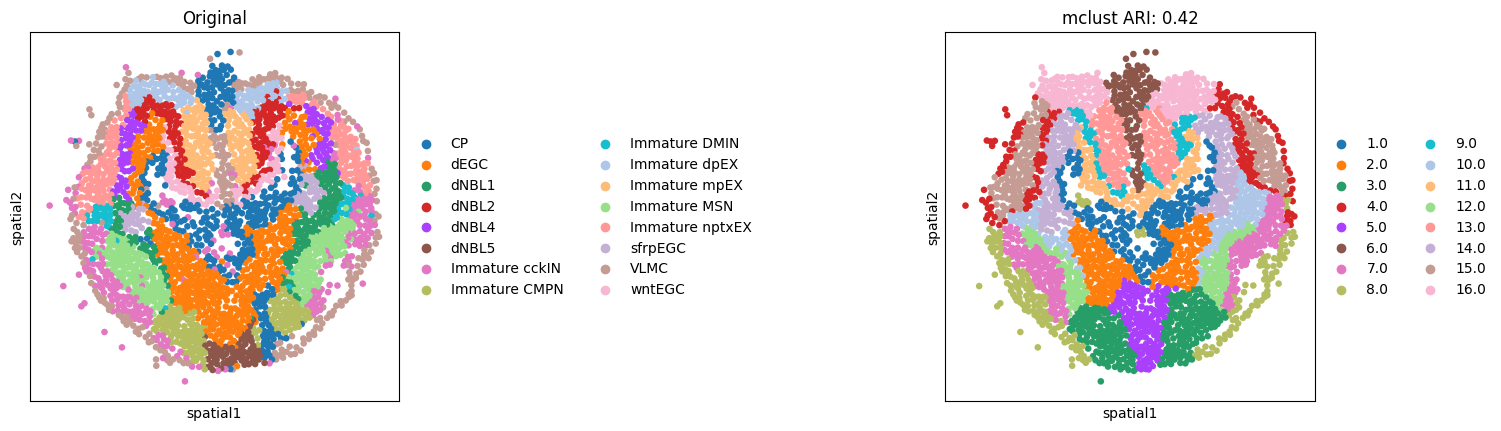

fitting ...
  |======================================================================| 100%


/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


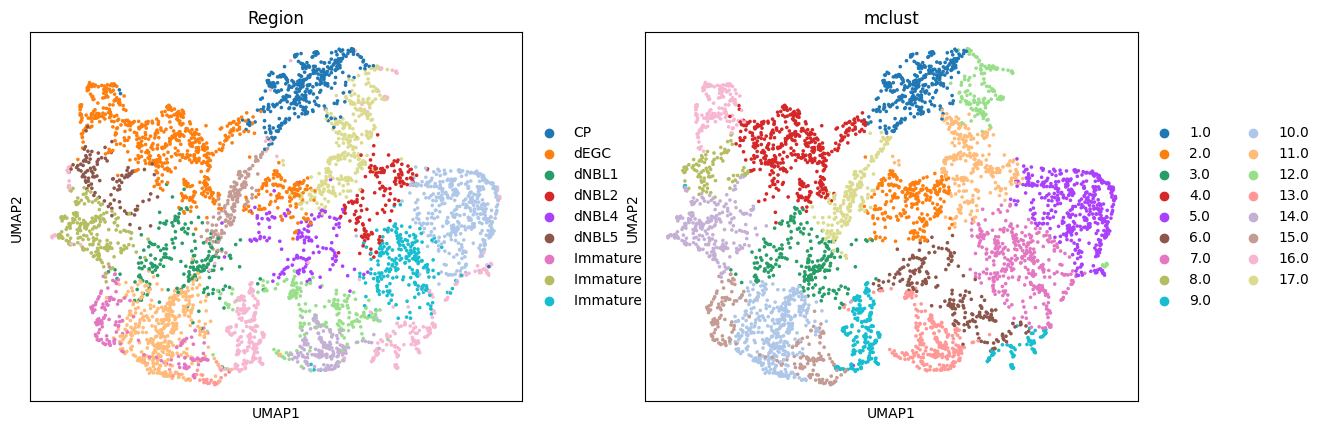

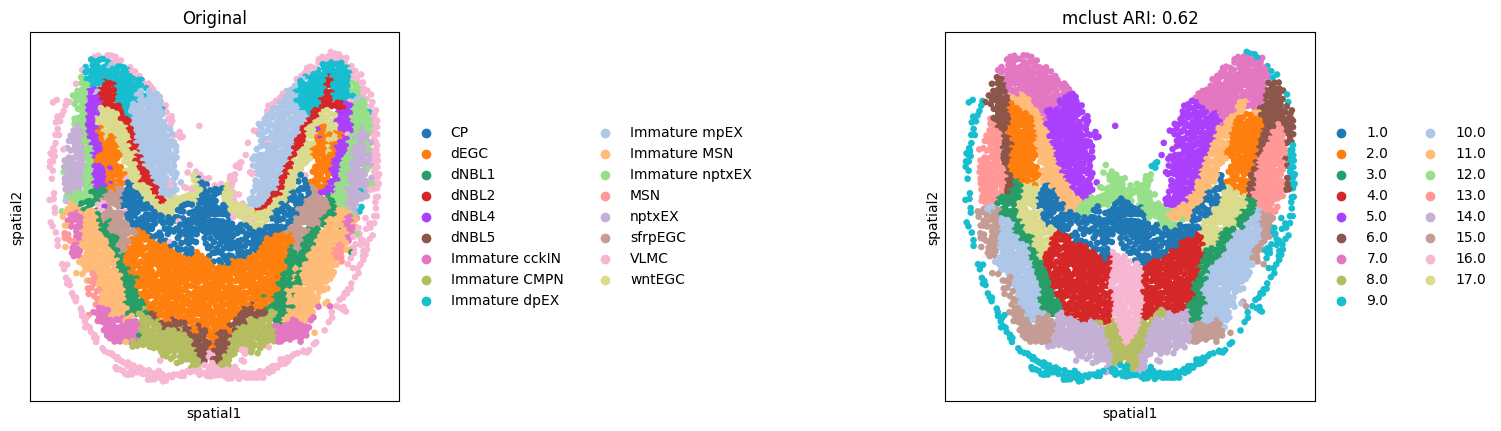

In [5]:
# spatial domain detection
adata1_leiden_result, adata1_louvain_result, adata1_mclust_result = metrics(adata1,
                                                                            save_loc='_Stereo-Seq_stage54.png',
                                                                            resolution=0.1,
                                                                            spot_size=0.02,
                                                                            cluster_label='Region',
                                                                            plot_color=["mclust"],
                                                                            mclust_model='EEE',
                                                                            embed_label='fused_embedding',
                                                                            vis=True,
                                                                            save=False)

adata2_leiden_result, adata2_louvain_result, adata2_mclust_result = metrics(adata2,
                                                                            save_loc='_Stereo-Seq_stage57.png',
                                                                            resolution=0.1,
                                                                            spot_size=0.02,
                                                                            cluster_label='Region',
                                                                            plot_color=["mclust"],
                                                                            mclust_model='EEE',
                                                                            embed_label='fused_embedding',
                                                                            vis=True,
                                                                            save=False)

## Batch effect correction

UMAP visualizations colored by ground truth annotation (left) and batches (right), illustrating that the model preserves true biological differences while achieving effective integration.

/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


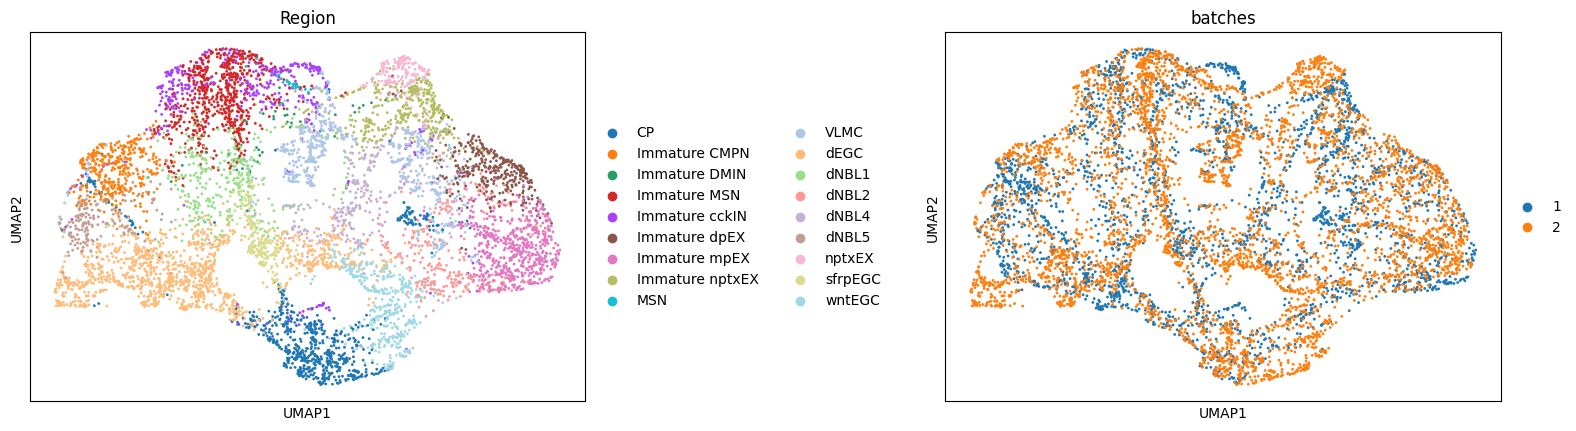

In [6]:
# batch effect correction (integration)
checkBatch(adata1, adata2, save=None)

## Show alignment

Alignment across slices, colored by region labels (300 alignment pairs shown for clarity)

dataset1: 16 cell types; dataset2: 17 cell types; 
                    Total :18 celltypes; Overlap: 15 cell types 
                    Not overlap :[['Immature DMIN', 'MSN', 'nptxEX']]
Subsampled 300 pairs from 661


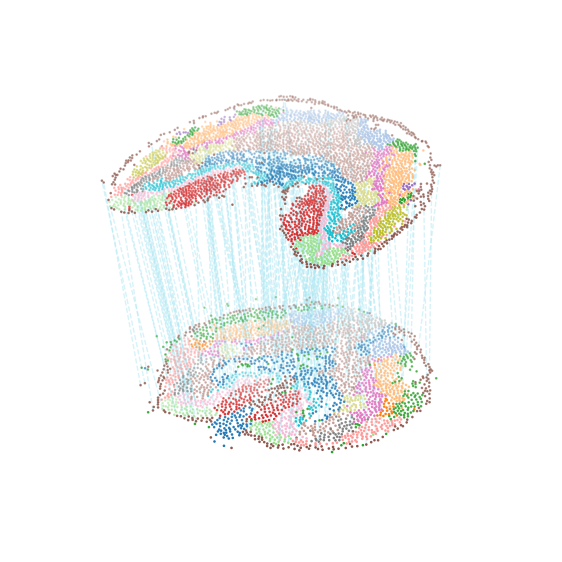

In [7]:
# show alignment
adata1_df = pd.DataFrame({'index': range(adata1.shape[0]),
                          'x': adata1.obsm['spatial'][:, 0],
                          'y': adata1.obsm['spatial'][:, 1],
                          'celltype': adata1.obs['Region']})
adata2_df = pd.DataFrame({'index': range(adata2.shape[0]),
                          'x': adata2.obsm['spatial'][:, 0],
                          'y': adata2.obsm['spatial'][:, 1],
                          'celltype': adata2.obs['Region']})
matching = np.array([trainer.match_in_adata1.data.cpu().numpy(), trainer.match_in_adata2.data.cpu().numpy()])
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)
multi_align.draw_3D(target='all_type', size=[7, 8], line_width=1, point_size=[0.8, 0.8], line_color='blue',
                    hide_axis=True, show_error=False, only_show_correct=True, only_show_error=False,
                    line_alpha=0.5)

## Spots mapping accuracy
The all_matching function returns two plots:
1. A Sankey plot illustrating spots type correspondence based on alignments from SpatialFuser.
2. A histogram showing the similarity score distributions from random matching (bottom) and SpatialFuser matching (top) in pairwise alignments.


QC threshold：0.95%  -> 0.8067
valid matching ratio：99.4% (2910/2929)
spots mapping acc：62.03% (1805/2910)


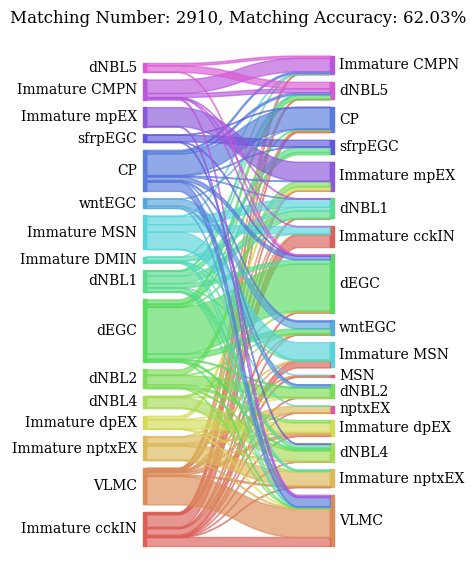

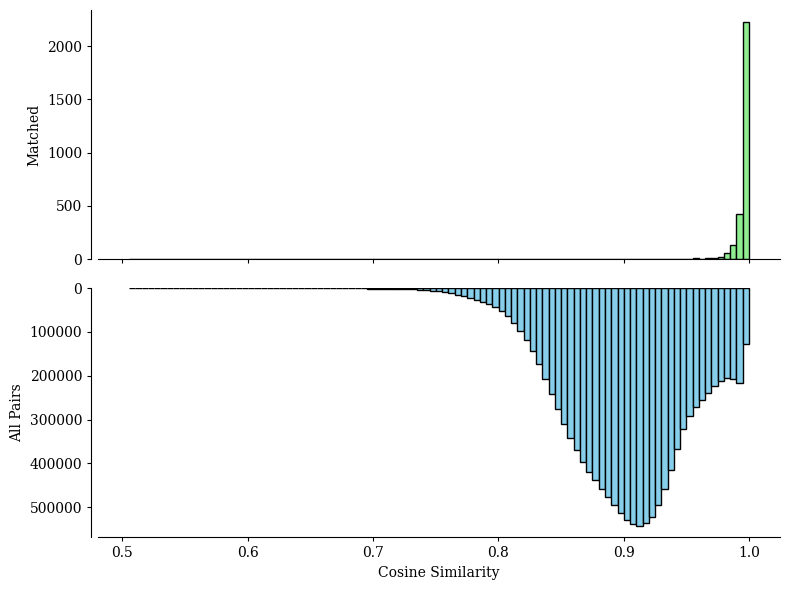

In [8]:
# evaluate alignment
valid_ratio, accuracy = all_matching(adata1, adata2, 0.95, 0.15, save_loc=None, file_name=None)